In [1]:
# API_KEY = 41ceac4b0e3ff85de45425deb48ec74435905a5b

In [55]:
!pip install flwr transformers datasets scikit-learn pandas torch --quiet

# flwr: federated learning
# transformers/datasets: NLP models & datasets
# scikit-learn: ML tools
# pandas: data handling
# torch: deep learning
# --quiet: suppress output


In [3]:
# Numerical and Data Handling Libraries
import numpy as np                    # For numerical computations
import pandas as pd                  # For data manipulation and analysis

# Visualization Libraries
import seaborn as sns                # For advanced data visualization
import matplotlib.pyplot as plt      # For plotting graphs

# PyTorch Libraries
import torch                         # Core PyTorch library
import torch.nn.functional as F      # For softmax and other neural network functions
from torch.utils.data import Dataset, random_split  # For custom dataset creation and dataset splitting

# Scikit-learn Libraries
from sklearn.preprocessing import LabelEncoder     # For encoding categorical labels
from sklearn.metrics import confusion_matrix, classification_report  # For model evaluation

# Hugging Face Transformers (NLP)
from transformers import BertTokenizer, BertForSequenceClassification  # Pre-trained BERT model and tokenizer
from transformers import Trainer, TrainingArguments                    # For training and evaluation

# Federated Learning Library
import flwr as fl                    # Flower - Federated Learning Framework

# Utility
import copy                          # For creating deep copies of objects


In [4]:
# Load dataset
df = pd.read_csv('Emotion_final.csv')

In [5]:
# Display the first 5 rows of the dataset
print("First 5 rows:")
print(df.head(), "\n")


First 5 rows:
                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger 



In [6]:
# Display column names
print("Column Names:")
print(df.columns.tolist(), "\n")


Column Names:
['Text', 'Emotion'] 



In [7]:
# Display data types and non-null counts
print("DataFrame Info:")
print(df.info(), "\n")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB
None 



In [8]:
# Display unique emotions and their counts
print("Class Distribution:")
print(df['Emotion'].value_counts(), "\n")

Class Distribution:
Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: count, dtype: int64 



In [9]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Emotion'])

# Print class-to-label mapping
print("Class to Label Mapping:")
for cls, lbl in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{cls}: {lbl}")

Class to Label Mapping:
anger: 0
fear: 1
happy: 2
love: 3
sadness: 4
surprise: 5


In [10]:
# Display data types and non-null counts
print("DataFrame Info:")
print(df.info(), "\n")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
 2   label    21459 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 503.1+ KB
None 



In [11]:
# Display the first 5 rows of the dataset
print("First 5 rows:")
print(df.head(), "\n")

First 5 rows:
                                                Text  Emotion  label
0                            i didnt feel humiliated  sadness      4
1  i can go from feeling so hopeless to so damned...  sadness      4
2   im grabbing a minute to post i feel greedy wrong    anger      0
3  i am ever feeling nostalgic about the fireplac...     love      3
4                               i am feeling grouchy    anger      0 



In [12]:
# Load the pre-trained BERT tokenizer (lowercase, uncased version)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# Custom PyTorch Dataset for Emotion Classification
class EmotionDataset(Dataset):

    def __init__(self, texts, labels):
        # Tokenize the input texts with padding and truncation
        self.encodings = tokenizer(texts, truncation=True, padding=True)
        self.labels = labels  # Store the corresponding labels

    def __getitem__(self, idx):
        # Retrieve the tokenized input at the given index
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        # Add the label corresponding to the index
        item['labels'] = torch.tensor(self.labels[idx])
        return item  # Return the dictionary containing input tensors and label

    def __len__(self):
        # Return the total number of samples
        return len(self.labels)


In [14]:
NUM_CLIENTS = 3  # Define the number of simulated clients

# Shuffle the dataset and split it evenly into NUM_CLIENTS parts
client_dfs = np.array_split(df.sample(frac=1).reset_index(drop=True), NUM_CLIENTS)

client_datasets = []  # List to store datasets for each client

# Create a separate EmotionDataset for each client
for client_df in client_dfs:
    texts = client_df['Text'].tolist()      # Extract text data
    labels = client_df['label'].tolist()    # Extract corresponding labels
    dataset = EmotionDataset(texts, labels) # Create a dataset for the client
    client_datasets.append(dataset)         # Add to the list of client datasets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:

# Function to initialize a new BERT model for sequence classification
def get_model():
    return BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=len(label_encoder.classes_)  # Set number of output labels
    )

# Function to return a HuggingFace Trainer instance for training/evaluation
def get_trainer(model, train_dataset, val_dataset=None):
    args = TrainingArguments(
        output_dir='./fl_client',                   # Directory to save model checkpoints/logs
        num_train_epochs=1,                         # Number of training epochs
        per_device_train_batch_size=8,              # Batch size for training
        per_device_eval_batch_size=8,               # Batch size for evaluation
        logging_dir='./logs',                       # Directory to store logs
        logging_steps=10,                           # Log every 10 steps
        save_strategy="no",                         # Disable model saving to avoid conflicts in FL
    )

    return Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset if val_dataset else None  # Optional validation dataset
    )

# Function to extract model weights and convert them to NumPy arrays (for federated learning)
def get_model_weights(model):
    return [val.cpu().detach().numpy() for val in model.state_dict().values()]

# Function to set model weights from NumPy arrays (used after aggregation)
def set_model_weights(model, weights):
    params_dict = zip(model.state_dict().keys(), weights)            # Pair parameter names with weights
    state_dict = {k: torch.tensor(v) for k, v in params_dict}        # Convert NumPy arrays back to tensors
    model.load_state_dict(state_dict, strict=True)                   # Load the new state into the model


In [16]:

# Initialize the global BERT model
global_model = get_model()

# Extract and store the initial weights of the global model
global_weights = get_model_weights(global_model)

# Define how many rounds of federated training to simulate
NUM_ROUNDS = 3

# Loop through each federated training round
for round_num in range(NUM_ROUNDS):
    print(f"🌍 Federated Round {round_num+1}")  # Print the current round

    local_weights = []  # List to store weights from each client after training

    # Iterate through each simulated client
    for client_id, client_dataset in enumerate(client_datasets):
        print(f"  🧑‍💻 Client {client_id+1} training...")  # Print which client is training

        # Create a fresh model for the client and load the current global weights
        local_model = get_model()
        set_model_weights(local_model, global_weights)

        # Split client data into training (80%) and validation (20%) sets
        train_size = int(0.8 * len(client_dataset))
        train_data, val_data = random_split(client_dataset, [train_size, len(client_dataset) - train_size])

        # Initialize the Trainer for local training
        trainer = get_trainer(local_model, train_data, val_data)
        trainer.train()  # Perform training on the local dataset

        # Collect the trained weights from this client
        local_weights.append(get_model_weights(local_model))

    # 🧮 Federated Averaging (FedAvg): average weights across all clients for each layer
    global_weights = [
        np.mean([client_weights[layer] for client_weights in local_weights], axis=0)
        for layer in range(len(global_weights))
    ]

# After all rounds, set the final averaged weights to the global model
set_model_weights(global_model, global_weights)

# ✅ Print completion message
print("✅ Federated training completed.")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🌍 Federated Round 1
  🧑‍💻 Client 1 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omkarauti11052001 (omkarauti11052001-walchand-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa


Step,Training Loss
10,1.720400
20,1.668500
30,1.646400
40,1.618100
50,1.651600
60,1.385700
70,1.357500
80,1.260200
90,1.256200
100,1.164100


  🧑‍💻 Client 2 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.752500
20,1.526600
30,1.568600
40,1.561200
50,1.324700
60,1.268000
70,1.392900
80,1.331000
90,1.126700
100,0.990300


  🧑‍💻 Client 3 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.686100
20,1.643900
30,1.609700
40,1.559500
50,1.492600
60,1.486700
70,1.257200
80,1.242300
90,1.193500
100,1.046200


🌍 Federated Round 2
  🧑‍💻 Client 1 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.460900
20,0.412600
30,0.395400
40,0.524600
50,0.271100
60,0.529700
70,0.457400
80,0.240200
90,0.203900
100,0.213700


  🧑‍💻 Client 2 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.323600
20,0.401900
30,0.361200
40,0.142300
50,0.168500
60,0.112400
70,0.180900
80,0.538300
90,0.609100
100,0.354000


  🧑‍💻 Client 3 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.179800
20,0.348500
30,0.361400
40,0.473500
50,0.368600
60,0.442200
70,0.258800
80,0.247400
90,0.403900
100,0.496500


🌍 Federated Round 3
  🧑‍💻 Client 1 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.219300
20,0.327100
30,0.121600
40,0.222200
50,0.077400
60,0.192600
70,0.329100
80,0.198600
90,0.110800
100,0.082400


  🧑‍💻 Client 2 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.049300
20,0.199100
30,0.135100
40,0.087200
50,0.062200
60,0.122900
70,0.114200
80,0.236900
90,0.510300
100,0.267800


  🧑‍💻 Client 3 training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.075400
20,0.317200
30,0.130600
40,0.197400
50,0.255100
60,0.339600
70,0.344300
80,0.157300
90,0.309200
100,0.361000


✅ Federated training completed.


In [30]:


# Dictionary to store metrics for each client
all_client_metrics = {}

# Loop through each client and evaluate
for client_id, client_dataset in enumerate(client_datasets):
    print(f"\n📈 Evaluating Client {client_id+1} Model...")

    # Create a new model and load the final global weights
    local_model = get_model()
    set_model_weights(local_model, global_weights)

    # Split client dataset into validation set (20%)
    eval_size = int(0.2 * len(client_dataset))
    _, eval_data = random_split(client_dataset, [len(client_dataset) - eval_size, eval_size])

    # Evaluate using the trainer
    trainer = get_trainer(local_model, None, eval_data)
    metrics = trainer.evaluate()

    # Store and display metrics
    all_client_metrics[f"Client_{client_id+1}"] = metrics
    print(metrics)

# ✅ Evaluate the final global model on client 0's validation data
print(f"\n🌐 Evaluating Final Global Model on Client 0's Validation Split...")

eval_size = int(0.2 * len(client_datasets[0]))
_, eval_data = random_split(client_datasets[0], [len(client_datasets[0]) - eval_size, eval_size])

trainer = get_trainer(global_model, None, eval_data)
global_metrics = trainer.evaluate()

print("📊 Final Global Model Evaluation Metrics:")
print(global_metrics)



📈 Evaluating Client 1 Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.23946744203567505, 'eval_model_preparation_time': 0.0054, 'eval_runtime': 8.6649, 'eval_samples_per_second': 165.033, 'eval_steps_per_second': 20.658}

📈 Evaluating Client 2 Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.2476644515991211, 'eval_model_preparation_time': 0.0142, 'eval_runtime': 7.3712, 'eval_samples_per_second': 193.997, 'eval_steps_per_second': 24.284}

📈 Evaluating Client 3 Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.26145899295806885, 'eval_model_preparation_time': 0.0123, 'eval_runtime': 8.3686, 'eval_samples_per_second': 170.878, 'eval_steps_per_second': 21.39}

🌐 Evaluating Final Global Model on Client 0's Validation Split...


📊 Final Global Model Evaluation Metrics:
{'eval_loss': 0.12285967916250229, 'eval_model_preparation_time': 0.0056, 'eval_runtime': 8.6699, 'eval_samples_per_second': 164.939, 'eval_steps_per_second': 20.646}


In [31]:

for client_id, client_dataset in enumerate(client_datasets):
    print(f"\n🧪 Classification Report for Client {client_id+1}:")

    # Create model with global weights
    local_model = get_model()
    set_model_weights(local_model, global_weights)

    # Split into evaluation set
    eval_size = int(0.2 * len(client_dataset))
    _, eval_data = random_split(client_dataset, [len(client_dataset) - eval_size, eval_size])

    # Create trainer and predict
    trainer = get_trainer(local_model, None, eval_data)
    predictions = trainer.predict(eval_data)
    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Decode numeric to string labels
    decoded_preds = label_encoder.inverse_transform(preds)
    decoded_labels = label_encoder.inverse_transform(true_labels)

    # Print classification report
    report = classification_report(decoded_labels, decoded_preds)
    print(report)

# 🌐 Final Global Model Classification Report on Client 0's Validation Set
print(f"\n🌍 Classification Report for Final Global Model (Client 0 Eval Split):")

eval_size = int(0.2 * len(client_datasets[0]))
_, eval_data = random_split(client_datasets[0], [len(client_datasets[0]) - eval_size, eval_size])

trainer = get_trainer(global_model, None, eval_data)
predictions = trainer.predict(eval_data)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

decoded_preds = label_encoder.inverse_transform(preds)
decoded_labels = label_encoder.inverse_transform(true_labels)

report = classification_report(decoded_labels, decoded_preds)
print(report)



🧪 Classification Report for Client 1:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

       anger       0.94      0.93      0.94       209
        fear       0.88      0.89      0.88       179
       happy       0.94      0.93      0.93       465
        love       0.81      0.82      0.82       114
     sadness       0.97      0.97      0.97       403
    surprise       0.75      0.75      0.75        60

    accuracy                           0.92      1430
   macro avg       0.88      0.88      0.88      1430
weighted avg       0.92      0.92      0.92      1430


🧪 Classification Report for Client 2:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

       anger       0.93      0.92      0.92       179
        fear       0.91      0.91      0.91       174
       happy       0.94      0.93      0.94       500
        love       0.81      0.81      0.81       106
     sadness       0.95      0.97      0.96       413
    surprise       0.79      0.83      0.81        58

    accuracy                           0.92      1430
   macro avg       0.89      0.89      0.89      1430
weighted avg       0.92      0.92      0.92      1430


🧪 Classification Report for Client 3:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

       anger       0.96      0.87      0.91       201
        fear       0.89      0.88      0.88       161
       happy       0.94      0.95      0.94       469
        love       0.82      0.83      0.82       117
     sadness       0.94      0.98      0.96       427
    surprise       0.85      0.82      0.83        55

    accuracy                           0.92      1430
   macro avg       0.90      0.89      0.89      1430
weighted avg       0.92      0.92      0.92      1430


🌍 Classification Report for Final Global Model (Client 0 Eval Split):


              precision    recall  f1-score   support

       anger       0.95      0.95      0.95       197
        fear       0.93      0.96      0.94       191
       happy       0.97      0.97      0.97       461
        love       0.89      0.87      0.88       116
     sadness       0.97      0.98      0.97       412
    surprise       0.94      0.85      0.89        53

    accuracy                           0.95      1430
   macro avg       0.94      0.93      0.93      1430
weighted avg       0.95      0.95      0.95      1430



In [52]:

# ✅ Use the global_model trained via federated learning to predict emotions on new text inputs

sample_texts = [
    "The excitement of finally landing my dream job was beyond words.",

    "I felt utterly helpless as I watched the storm tear through the town.",

    "Seeing my old friend after years only sparked a rage I couldn't control. How could they betray me like that? All the years of friendship feel like a slap in the face now.",

    "The thought of failing the exam made my heart race with anxiety.",

    "I felt a deep sense of love when I saw my family gathered together.",

    "I walked into the room, and suddenly everyone shouted, 'Surprise!' I had no idea they were planning this for me."
]


# 🔤 Tokenize the input texts using the same tokenizer used during training
sample_encodings = tokenizer(sample_texts, truncation=True, padding=True, return_tensors='pt')

# 💻 Move the model and input tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model.to(device)
sample_encodings = {k: v.to(device) for k, v in sample_encodings.items()}

# 🔮 Perform inference using the trained global model
global_model.eval()
with torch.no_grad():
    outputs = global_model(**sample_encodings)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    confidences, predictions = torch.max(probs, dim=1)

# Convert to CPU for readability
predicted_emotions = label_encoder.inverse_transform(predictions.cpu().numpy())
confidences = confidences.cpu().numpy()
all_probs = probs.cpu().numpy()
all_labels = label_encoder.classes_

# 🖨️ Print predictions with confidence and full class probability breakdown
for idx, (text, emotion, confidence, prob_dist) in enumerate(zip(sample_texts, predicted_emotions, confidences, all_probs)):
    print(f"\n📝 Text {idx+1}: {text}")
    print(f"🔮 Predicted Emotion: {emotion} (Confidence: {confidence*100:.2f}%)")

    # Show all class confidence scores
    sorted_indices = np.argsort(prob_dist)[::-1]
    print("📊 Confidence by Class:")
    for i in sorted_indices:
        print(f"   - {all_labels[i]}: {prob_dist[i]*100:.2f}%")



📝 Text 1: The excitement of finally landing my dream job was beyond words.
🔮 Predicted Emotion: happy (Confidence: 99.94%)
📊 Confidence by Class:
   - happy: 99.94%
   - love: 0.03%
   - surprise: 0.01%
   - sadness: 0.01%
   - anger: 0.01%
   - fear: 0.01%

📝 Text 2: I felt utterly helpless as I watched the storm tear through the town.
🔮 Predicted Emotion: sadness (Confidence: 91.47%)
📊 Confidence by Class:
   - sadness: 91.47%
   - fear: 8.13%
   - surprise: 0.19%
   - anger: 0.09%
   - happy: 0.07%
   - love: 0.04%

📝 Text 3: Seeing my old friend after years only sparked a rage I couldn't control. How could they betray me like that? All the years of friendship feel like a slap in the face now.
🔮 Predicted Emotion: anger (Confidence: 99.70%)
📊 Confidence by Class:
   - anger: 99.70%
   - sadness: 0.19%
   - fear: 0.08%
   - happy: 0.01%
   - love: 0.01%
   - surprise: 0.01%

📝 Text 4: The thought of failing the exam made my heart race with anxiety.
🔮 Predicted Emotion: fear (Confide

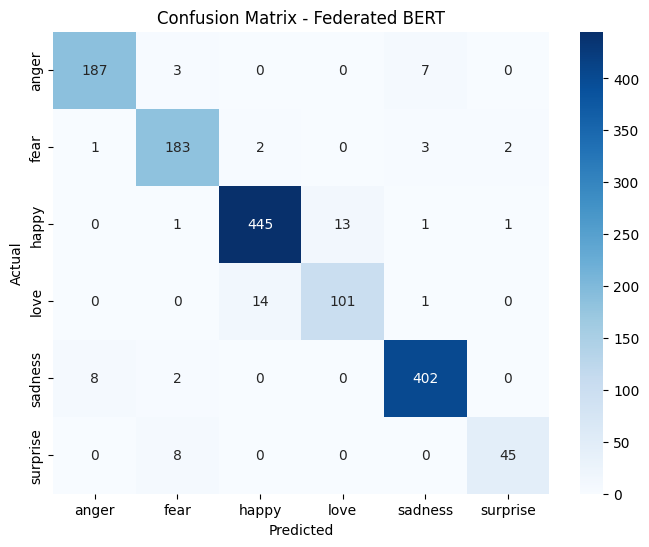

In [39]:

# Step 1: Get predictions on validation data
eval_size = int(0.2 * len(client_datasets[0]))  # 20% of the first client's dataset for validation
_, eval_data = random_split(client_datasets[0], [len(client_datasets[0]) - eval_size, eval_size])

trainer = get_trainer(global_model, None, eval_data)  # Using global_model for inference
predictions = trainer.predict(eval_data)  # Get predictions from the model

# Step 2: Extract predictions and labels
preds = np.argmax(predictions.predictions, axis=1)  # Get predicted labels (argmax of logits)
true_labels = predictions.label_ids  # Actual ground truth labels

# Step 3: Compute confusion matrix
cm = confusion_matrix(true_labels, preds)  # Compute confusion matrix using true and predicted labels

# Extract emotion labels (classes)
emotion_labels = label_encoder.classes_

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8,6))  # Set figure size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",  # Annotate the matrix with counts and use a color map
            xticklabels=emotion_labels, yticklabels=emotion_labels)  # Label the axes with emotion names
plt.xlabel("Predicted")  # Label for the X-axis
plt.ylabel("Actual")  # Label for the Y-axis
plt.title("Confusion Matrix - Federated BERT")  # Title of the plot
plt.show()  # Display the plot


In [43]:
# Save the trained global model to a directory for future use or deployment
global_model.save_pretrained("./final_federated_model")

# Save the tokenizer used during training for tokenizing inputs during inference
tokenizer.save_pretrained("./final_federated_model")


('./final_federated_model/tokenizer_config.json',
 './final_federated_model/special_tokens_map.json',
 './final_federated_model/vocab.txt',
 './final_federated_model/added_tokens.json')

In [53]:

# Step 1: Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained("./final_federated_model")
tokenizer = BertTokenizer.from_pretrained("./final_federated_model")

# Load the label encoder (make sure it's stored correctly, for example from a previous training session)
# label_encoder = LabelEncoder()
# label_encoder.classes_ = np.load('label_encoder_classes.npy')  # if saved earlier

sample_texts = [
    "The excitement of finally landing my dream job was beyond words.",

    "I felt utterly helpless as I watched the storm tear through the town.",

    "Seeing my old friend after years only sparked a rage I couldn't control. How could they betray me like that? All the years of friendship feel like a slap in the face now.",

    "The thought of failing the exam made my heart race with anxiety.",

    "I felt a deep sense of love when I saw my family gathered together.",

    "I walked into the room, and suddenly everyone shouted, 'Surprise!' I had no idea they were planning this for me."
]


# Step 3: Tokenize the input texts
sample_encodings = tokenizer(sample_texts, truncation=True, padding=True, return_tensors='pt')

# Step 4: Move the model and input tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
sample_encodings = {k: v.to(device) for k, v in sample_encodings.items()}

# Step 5: Perform inference using the loaded model
model.eval()
with torch.no_grad():
    outputs = model(**sample_encodings)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    confidences, predictions = torch.max(probs, dim=1)

# Step 6: Convert predictions to emotion labels (using the loaded label encoder)
predicted_emotions = label_encoder.inverse_transform(predictions.cpu().numpy())
confidences = confidences.cpu().numpy()
all_probs = probs.cpu().numpy()
all_labels = label_encoder.classes_

# Step 7: Print predictions with confidence and class breakdown
for idx, (text, emotion, confidence, prob_dist) in enumerate(zip(sample_texts, predicted_emotions, confidences, all_probs)):
    print(f"\n📝 Text {idx+1}: {text}")
    print(f"🔮 Predicted Emotion: {emotion} (Confidence: {confidence*100:.2f}%)")

    # Show all class confidence scores
    sorted_indices = np.argsort(prob_dist)[::-1]  # Sort the probabilities in descending order
    print("📊 Confidence by Class:")
    for i in sorted_indices:
        print(f"   - {all_labels[i]}: {prob_dist[i]*100:.2f}%")



📝 Text 1: The excitement of finally landing my dream job was beyond words.
🔮 Predicted Emotion: happy (Confidence: 99.94%)
📊 Confidence by Class:
   - happy: 99.94%
   - love: 0.03%
   - surprise: 0.01%
   - sadness: 0.01%
   - anger: 0.01%
   - fear: 0.01%

📝 Text 2: I felt utterly helpless as I watched the storm tear through the town.
🔮 Predicted Emotion: sadness (Confidence: 91.47%)
📊 Confidence by Class:
   - sadness: 91.47%
   - fear: 8.13%
   - surprise: 0.19%
   - anger: 0.09%
   - happy: 0.07%
   - love: 0.04%

📝 Text 3: Seeing my old friend after years only sparked a rage I couldn't control. How could they betray me like that? All the years of friendship feel like a slap in the face now.
🔮 Predicted Emotion: anger (Confidence: 99.70%)
📊 Confidence by Class:
   - anger: 99.70%
   - sadness: 0.19%
   - fear: 0.08%
   - happy: 0.01%
   - love: 0.01%
   - surprise: 0.01%

📝 Text 4: The thought of failing the exam made my heart race with anxiety.
🔮 Predicted Emotion: fear (Confide